# Spectroscopic Trace tutorial

This tutorial will walk through the derivation of a spectroscopic trace model and extraction using astropy tools.

A spectroscopic trace is the path of a point source (star) spectrum through a two-dimensional dispersed spectrum.  The trace is needed because, in general, spectra are not perfectly aligned with the axes of a detector.

# Step 1: Examine the spectrum

We'll work with a 2D spectrum that contains *no* attached metadata, so we have to infer many of the features ourselves.

All we know is that this is a spectrum of a star, Aldebaran.

Our data are, strangely, in the form of .bmp (bitmap) files, so we need PIL (Python Imaging Library) to open them.

In [1]:
from PIL import Image
import numpy as np

In [2]:
spectrum_filename = "aldebaran_3s_1.bmp"

In [3]:
image_data = Image.open(spectrum_filename)

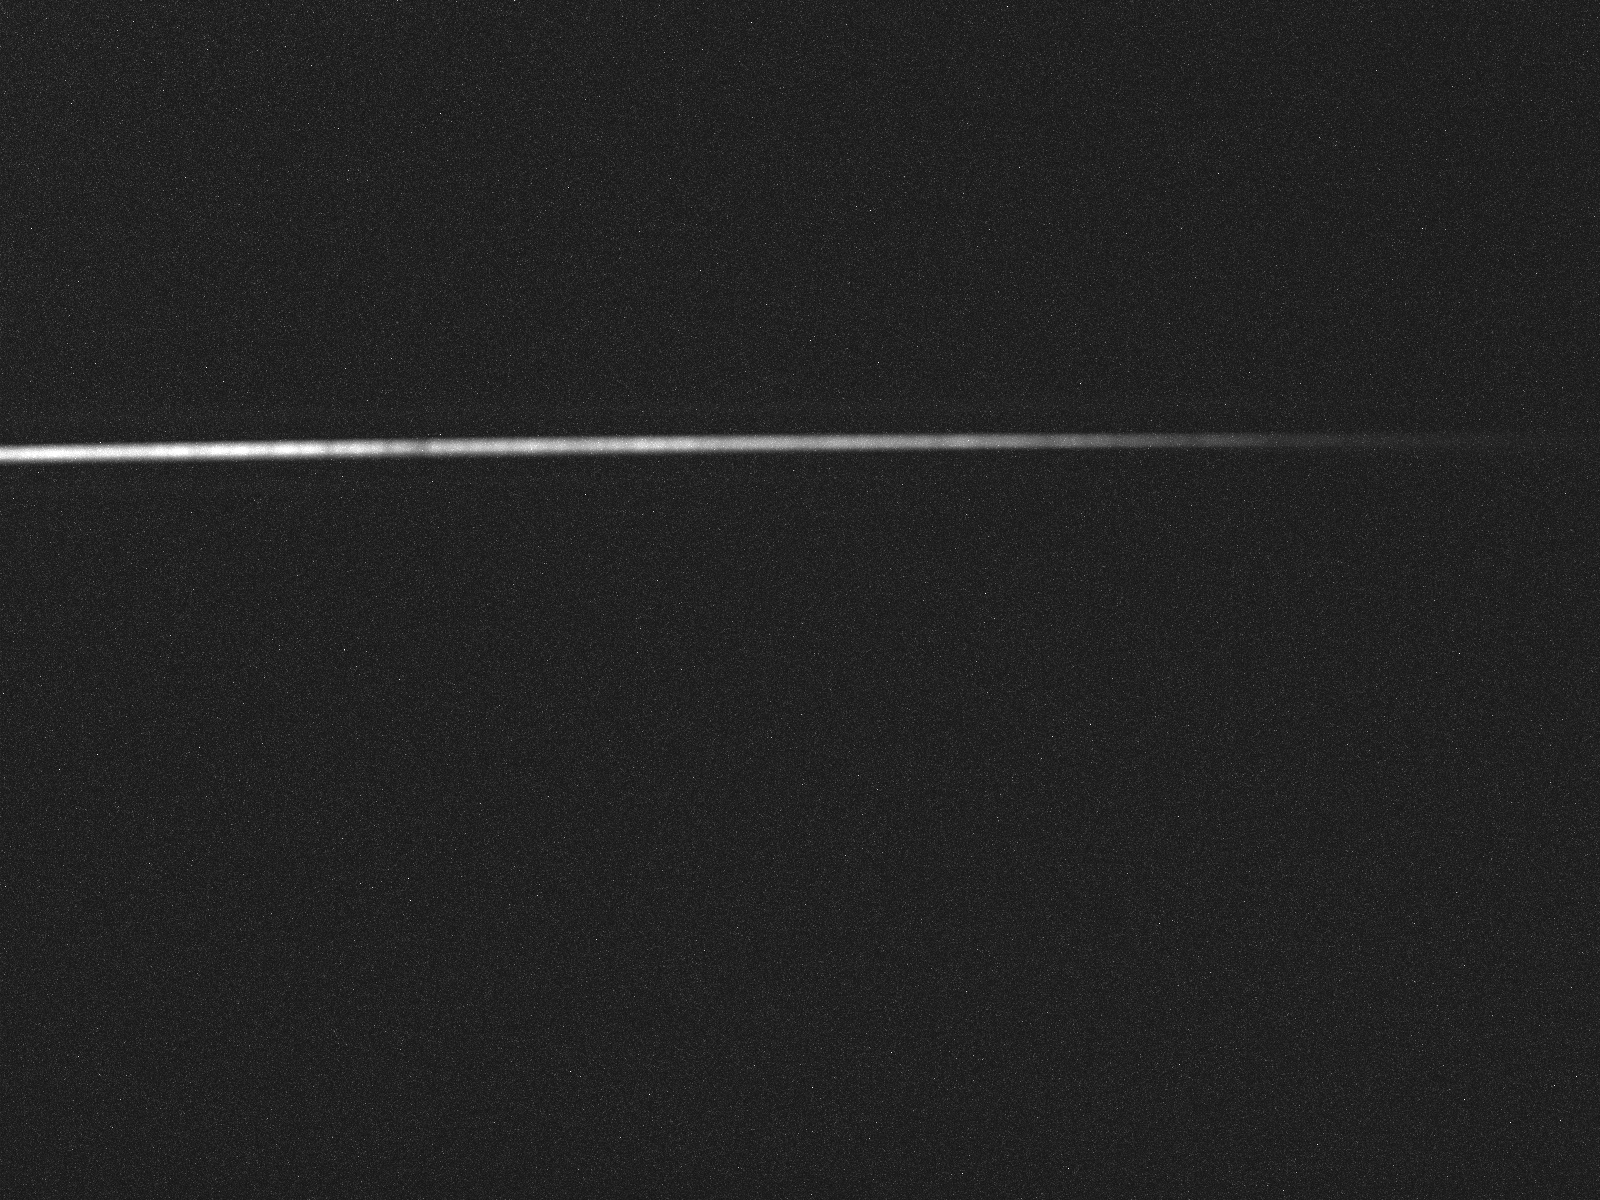

In [4]:
# because this is an image, simply entering on the command line will show it
image_data

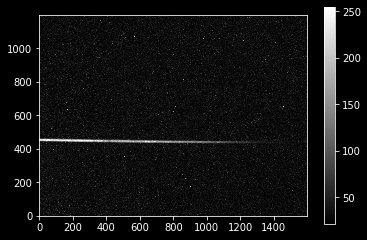

In [5]:
# but we'd like to see it with axes labeled
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(image_data, cmap='gray')
pl.colorbar()

The main goal of the trace is to obtain a two-dimensional model `f(x)` defining the position of the light along the detector.

We're going to start by assuming that wavelength dispersion is in the X-direction and the Y-direction is entirely spatial.  This is an approximation, but evidently (by looking at the image), it's a decent one.

# Step 2a. Try to find the spine to trace using argmax

To obtain the trace, we first measure the Y-value at each X-value.  we'll start with the trivial approach of using `argmax`:

In [6]:
yvals = np.argmax(image_data, axis=0)
xvals = np.arange(image_data.width)

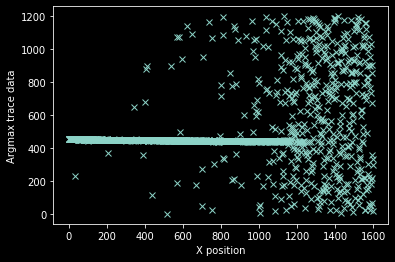

In [7]:
_=pl.plot(xvals, yvals, 'x')
_=pl.ylabel("Argmax trace data")
_=pl.xlabel("X position")

There's a pretty clear line going through, but also a lot of junk.

We can get rid of most of the junk just by filtering it out:

In [8]:
bad_pixels = (yvals < 400) | (yvals > 500)

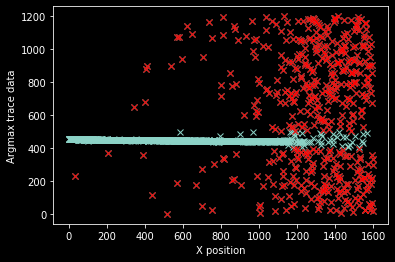

In [9]:
_=pl.plot(xvals, yvals, 'x')
_=pl.plot(xvals[bad_pixels], yvals[bad_pixels], 'rx')
_=pl.ylabel("Argmax trace data")
_=pl.xlabel("X position")

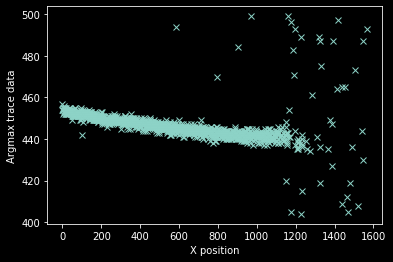

In [10]:
_=pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], 'x')
_=pl.ylabel("Argmax trace data")
_=pl.xlabel("X position")

In [11]:
# we can be a little more precise, so refine the mask once more
bad_pixels = (yvals < 425) | (yvals > 460)

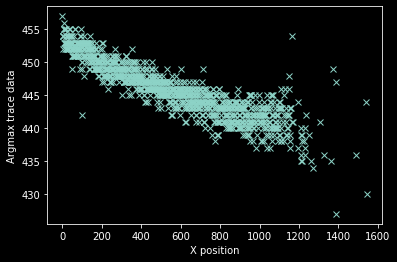

In [12]:
_=pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], 'x')
_=pl.ylabel("Argmax trace data")
_=pl.xlabel("X position")

The stuff at x>1100 looks bad, but there's still signal out there.

We can see there is clear signal out to nearly pixel ~1400:

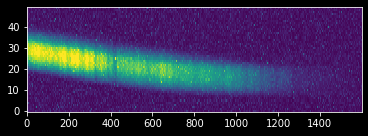

In [13]:
image_array = np.array(image_data)
image_array = image_array - np.median(image_array)
pl.imshow(image_array[425:475,:])
pl.gca().set_aspect(10)

# Step 2b: Use moment analysis to extract a spine to trace

We can use moments to get measurements of all the data.

Note that we need to subtract off the background to avoid a bias toward the center, so we use the median of the image as our background estimate.

In [14]:
# we use a cutout around the traced line, so the Y-values are from that cutout
yaxis = np.repeat(np.arange(425, 475)[:,None],
                  image_array.shape[1], axis=1)
# moment 1 is the data-weighted average of the Y-axis coordinates
weighted_yaxis_values = np.average(yaxis, axis=0,
                                   weights=image_array[425:475,:] - np.median(image_array))

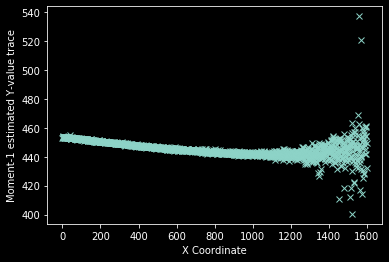

In [15]:
_=pl.plot(xvals, weighted_yaxis_values, 'x')
_=pl.xlabel("X Coordinate")
_=pl.ylabel("Moment-1 estimated Y-value trace")

Overplot the "weighted", centroid locations on the data to verify they look reasonable.

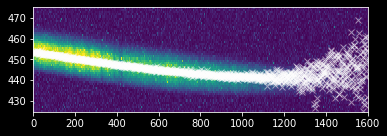

In [16]:
# we need to use the 'extent' keyword to have the axes correctly labeled
_=pl.imshow(image_array[425:475,:],
            extent=[0,image_array.shape[1],425,475])
_=pl.gca().set_aspect(10) # we stretch the image out by 10x in the y-direction
_=pl.plot(xvals, weighted_yaxis_values, 'wx', alpha=0.5)
_=pl.axis((0,1600,425,475))

We can also compare the argmax and weighted approaches.  They agree well at x<1200, but there are simply more points from the weighted approach at x>1200.

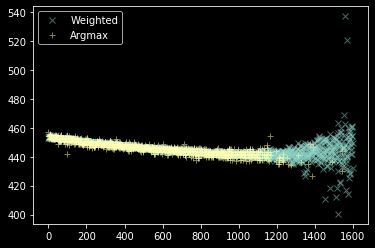

In [17]:
_=pl.plot(xvals, weighted_yaxis_values, 'x', label="Weighted", alpha=0.5)
_=pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], '+', label="Argmax", alpha=0.5)
_=pl.legend(loc='best')

That's a decent set of data, we'll use the moments instead of the argmax.  There's still some data to flag out, though:

In [18]:
bad_moments = (weighted_yaxis_values > 460) | (weighted_yaxis_values < 430)

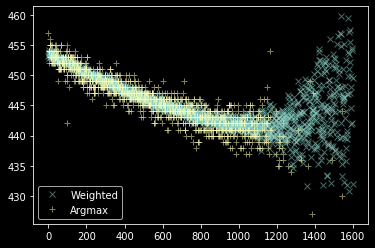

In [19]:
_=pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x', label="Weighted", alpha=0.5)
_=pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], '+', label="Argmax", alpha=0.5)
_=pl.legend(loc='best')

# Step 3. Fit the trace profile

We want a model `f(x)` that gives the y-value of the centroid as a function of x.

In [20]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [21]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(polymodel, xvals[~bad_moments], weighted_yaxis_values[~bad_moments])

In [22]:
fitted_polymodel

<Polynomial1D(2, c0=454.80138106, c1=-0.02381282, c2=0.00001121)>

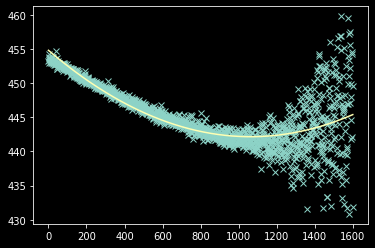

In [23]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x')
pl.plot(xvals, fitted_polymodel(xvals))

We check the residuals to see if the fit is good:

Text(0, 0.5, 'Residual (data-model)')

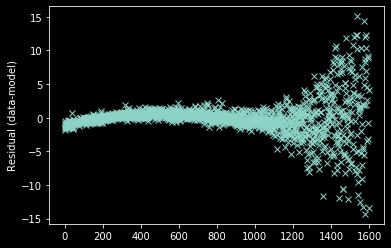

In [24]:
_= pl.plot(xvals[~bad_moments],
          weighted_yaxis_values[~bad_moments] - fitted_polymodel(xvals[~bad_moments]), 'x')
pl.ylabel("Residual (data-model)")

The curvature seen at the left is not good; we want to get rid of that.  We can fit a higher order model.

In [25]:
polymodel = Polynomial1D(degree=3)
fitted_polymodel = linfitter(polymodel, xvals[~bad_moments], weighted_yaxis_values[~bad_moments])
fitted_polymodel

<Polynomial1D(3, c0=453.31622273, c1=-0.01256666, c2=-0.00000651, c3=0.00000001)>

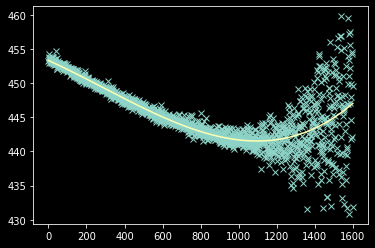

In [26]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x')
pl.plot(xvals, fitted_polymodel(xvals))

Text(0, 0.5, 'Residual (data-model)')

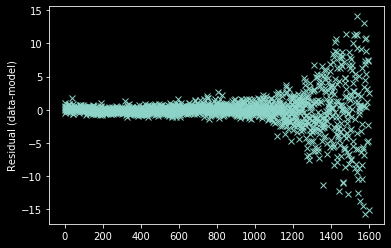

In [27]:
_= pl.plot(xvals[~bad_moments],
          weighted_yaxis_values[~bad_moments] - fitted_polymodel(xvals[~bad_moments]), 'x')
pl.ylabel("Residual (data-model)")

Arguably, we should toss out the data at >1400 pixels since there's no clear signal there.  We'll come back to this...

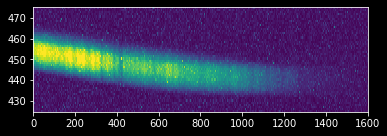

In [28]:
_=pl.imshow(image_array[425:475,:],
            extent=[0,image_array.shape[1],425,475])
_=pl.gca().set_aspect(10) 

Again, we should verify the trace by overplotting on the original data:

(0, 1600, 425, 475)

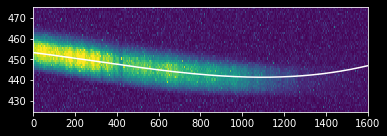

In [29]:
pl.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10)
pl.plot(xvals, fitted_polymodel(xvals), 'w')
pl.axis((0,1600,425,475))

Seeing this prompts me to say we should re-fit without including the x>1300 data at all, and we should stick to a second-order fit:

In [30]:
polymodel = Polynomial1D(degree=2)
fitted_polymodel = linfitter(polymodel, xvals[(~bad_moments) & (xvals < 1300)],
                             weighted_yaxis_values[(~bad_moments) & (xvals < 1300)])
fitted_polymodel

<Polynomial1D(2, c0=453.99089409, c1=-0.01931577, c2=0.00000731)>

(0, 1600, 425, 475)

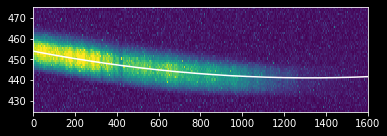

In [31]:
pl.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10)
pl.plot(xvals, fitted_polymodel(xvals), 'w')
pl.axis((0,1600,425,475))

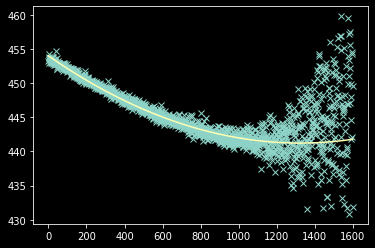

In [32]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x')
pl.plot(xvals, fitted_polymodel(xvals))

# Step 4. Obtain a trace profile

Now we can extract the data along that trace.

We want to take a "profile" of the trace to see how many pixels on either side of the line we should include.

(0, 1600, 425, 475)

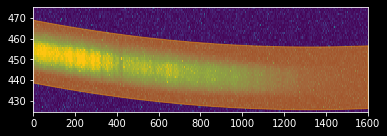

In [33]:
pl.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
pl.gca().set_aspect(10)
pl.fill_between(xvals, fitted_polymodel(xvals)-15,
                fitted_polymodel(xvals)+15,
                color='orange', alpha=0.5)
pl.axis((0,1600,425,475))

In [34]:
# start by taking +/- 15 pixels
npixels_to_cut = 15
trace_center = fitted_polymodel(xvals)
cutouts = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])
cutouts.shape

(1600, 30)

That last step deserves some explanation:
``cutouts = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])``

* `[... for yval, ii in zip(trace_center, xvals)]` takes each trace y-value and each x-value and 'zips' them together, so each iteration of the for loop has one x, y pair
* `image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]` is taking a single pixel along the x-direction (the second dimension, `ii`) and a range of pixels along the y-direction, i.e., `y+/-n`
* these are put together in a loop, so we have a y+/-n pixel region for each x-pixel
* then we make them all into an array
                

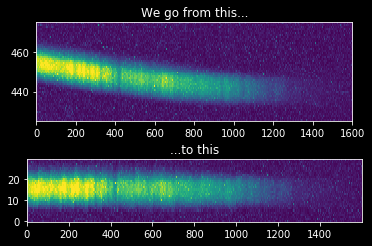

In [35]:
ax1 = pl.subplot(2,1,1)
ax1.imshow(image_array[425:475,:], extent=[0,image_array.shape[1],425,475])
ax1.set_aspect(10)
ax1.set_title("We go from this...")
ax2 = pl.subplot(2,1,2)
ax2.imshow(cutouts.T)
ax2.set_title("...to this")
ax2.set_aspect(10)

Then we average along the X-direction to get the trace profile:

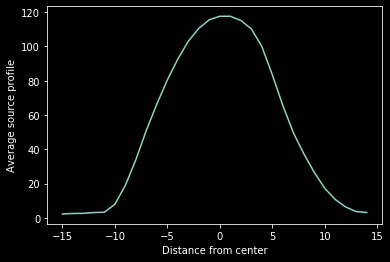

In [36]:
mean_trace_profile = cutouts.mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
_=pl.plot(trace_profile_xaxis, mean_trace_profile)
_=pl.xlabel("Distance from center")
_=pl.ylabel("Average source profile")

Now we want to fit that profile with a Gaussian, so we import the Gaussian model profile and non-linear fitter and run a fit:

In [37]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=mean_trace_profile)
model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
fitted_trace_profile

<Gaussian1D(amplitude=123.81906886, mean=0.17890498, stddev=5.10870321)>

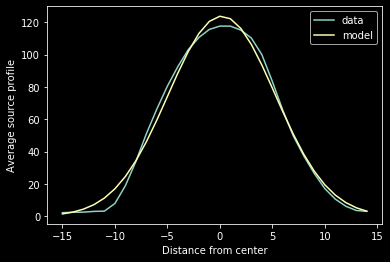

In [38]:
_=pl.plot(trace_profile_xaxis, mean_trace_profile, label='data')
_=pl.plot(trace_profile_xaxis, model_trace_profile, label='model')
_=pl.legend(loc='best')
_=pl.xlabel("Distance from center")
_=pl.ylabel("Average source profile")

# Step 5. Extract the traced spectrum

We can obtain our spectrum by directly averaging the pixels along the trace:

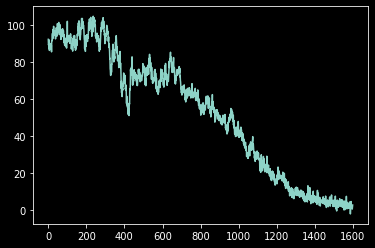

In [39]:
average_spectrum = cutouts.mean(axis=1)
_=pl.plot(average_spectrum)

Or, we can obtain our spectrum by taking the trace-weighted average:    

In [40]:
trace_avg_spectrum = np.array([np.average(
    image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
    weights=mean_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

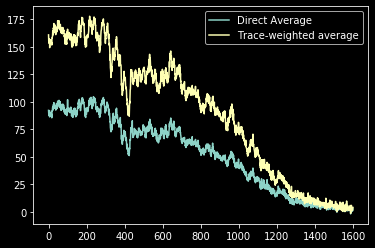

In [41]:
_=pl.plot(average_spectrum, label="Direct Average")
_=pl.plot(trace_avg_spectrum, label='Trace-weighted average')
_=pl.legend(loc='best')

In general, the trace-weighted average will have higher signal-to-noise.

# Step 6: Repeat for another star

In this last step, we go through all the above steps again, but with less explanation.

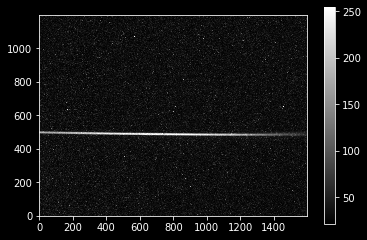

In [42]:
image_array_2 = np.array(Image.open('deneb_3s_13.63g_1.bmp'))
pl.imshow(image_array_2, cmap='gray')
pl.colorbar()

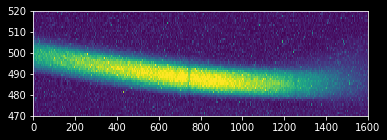

In [43]:
pl.imshow(image_array_2[470:520,:], extent=[0,1600,470,520])
pl.gca().set_aspect(10)

In [44]:
yaxis2 = np.repeat(np.arange(470, 520)[:,None], image_array_2.shape[1], axis=1)
weighted_yaxis_values2 = np.average(yaxis2, axis=0, weights=image_array_2[470:520,:] - np.median(image_array_2))
polymodel2 = Polynomial1D(degree=3)
fitted_polymodel2 = linfitter(polymodel2, xvals, weighted_yaxis_values2)
trace_center2 = fitted_polymodel2(xvals)

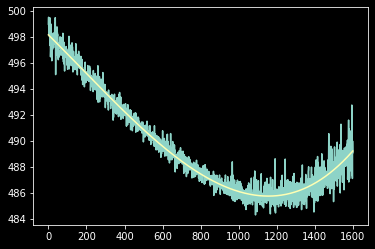

In [45]:
pl.plot(xvals, weighted_yaxis_values2)
pl.plot(xvals, trace_center2)

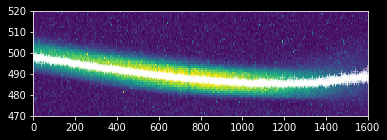

In [46]:
pl.imshow(image_array_2[470:520,:], extent=[0,1600,470,520])
pl.plot(xvals, trace_center2, color='k')
pl.plot(xvals, weighted_yaxis_values2, 'w+', alpha=0.5)
pl.gca().set_aspect(10)

In [47]:
spectrum2 = np.array([np.average(image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=mean_trace_profile)
                     for yval, ii in zip(trace_center2, xvals)])

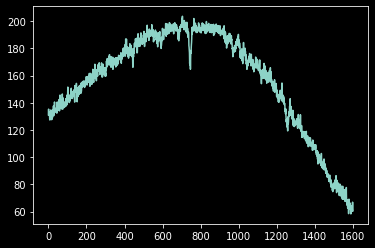

In [48]:
pl.plot(spectrum2)

DONE!  You have traced and extracted a spectrum.

Next, wavelength-calibrate it.